In [ ]:
import torch
from torch import nn
from torchinfo import summary
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

from going_modular.custom_data_setup_main_train import LoadDataset
from going_modular import engine, utils
from going_modular import custom_data_setup_pre_train
from going_modular.OneHeadModel import OneHeadModel
import helper_functions

c:\Users\User\.conda\envs\EnvMasoudi\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\User\.conda\envs\EnvMasoudi\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
allow_train = False
EPOCHS = 20
BATCH_SIZE = 64
shrink_size = None

crop_size = 380

num_augs = 0
p_dropout = 0.3
lr = 0.01
weight_deacay = 1e-5
T_max = 20
eta_min = 1e-4
momentum = 0.0

freeze_encoder = False

In [3]:
# Set matmul precision for TF32 usage on Ampere+ GPUs
# torch.set_float32_matmul_precision('medium')

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Augmentation

In [4]:
train_transforms = helper_functions.get_augmentation_train_transforms(num_augs, crop_size)
test_transforms = helper_functions.get_augmentation_test_transforms(crop_size)
no_transforms = helper_functions.get_augmentation_no_transforms(crop_size)

In [ ]:
# load all dataloaders

train_dataloader, class_names = custom_data_setup_pre_train.create_train_dataloader(
    transform=train_transforms, 
    batch_size=BATCH_SIZE,
    shrink_size=shrink_size) 

train_exp_dataloader, class_names = custom_data_setup_pre_train.create_train_dataloader(
    transform=test_transforms,
    batch_size=BATCH_SIZE,
    shrink_size=shrink_size) 

val_dataloader, class_names = custom_data_setup_pre_train.create_test_dataloader(
    transform=test_transforms, 
    batch_size=BATCH_SIZE,
    shrink_size=shrink_size) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


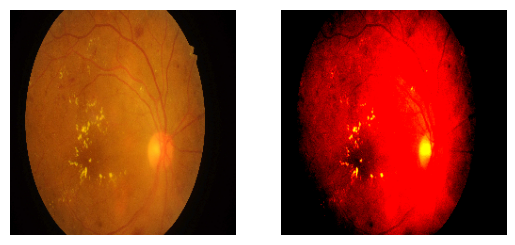

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.2489083].


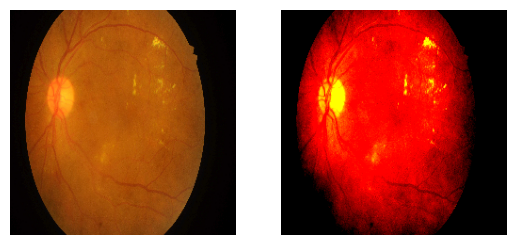

In [ ]:
# plot some of the images to check applied augmentations

IDRID_image_folder = "../IDRID/Imagenes/Imagenes" 
IDRID_csv_file = "../IDRID/idrid_labels.csv"  

test_dataset_with_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=train_transforms)
test_dataset_no_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=no_transforms)

for i in range(1):
    img_2 = test_dataset_with_transform[i][0].permute(1, 2, 0)
    img_1 = test_dataset_no_transform[i][0].permute(1, 2, 0)
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(img_1.numpy())
    axes[1].imshow(img_2.numpy())
    axes[0].axis(False)
    axes[1].axis(False)
    plt.show()

In [ ]:
model = OneHeadModel(device=device, p_dropout=p_dropout).to(device)

In [8]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
if freeze_encoder:
    for param in model.encoder.parameters():
        param.requires_grad = False

In [9]:
# Print a summary using torchinfo (uncomment for actual output)
torch.manual_seed(33)
summary(
model=model, 
input_size=(32, 3, crop_size, crop_size), # make sure this is "input_size", not "input_shape"
col_names=["input_size", "output_size", "num_params", "trainable"],
col_width=20,
row_settings=["var_names"]) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ThreeHeadCNN (ThreeHeadCNN)                                  [32, 3, 240, 240]    [32, 5]              --                   True
├─Sequential (encoder)                                       [32, 3, 240, 240]    [32, 1280, 8, 8]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 240, 240]    [32, 32, 120, 120]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 240, 240]    [32, 32, 120, 120]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 120, 120]   [32, 32, 120, 120]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 120, 120]   [32, 32, 120, 120]   --                   --
│    └─Sequential (1)                                        [32, 32, 120, 120]   [32, 16, 120

In [10]:
# Define loss and optimizer

# weight = torch.tensor([1/1805, 1/370, 1/999, 1/193, 1/295]) * 500 
# weight.to(device)

# loss_fn_classification = nn.CrossEntropyLoss(weight=weight, label_smoothing=0.1).to(device)
loss_fn_classification = nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_deacay)
scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

In [11]:
train_results = []

if allow_train:
    # Set the random seeds
    torch.manual_seed(1404)
    torch.cuda.manual_seed(1404)

    # Start the timer
    from timeit import default_timer as timer 
    start_time = timer()

    # Setup training and save the results
    train_results, val_results = engine.pre_train(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        optimizer=optimizer,
        scheduler=scheduler,
        loss_fn_classification=loss_fn_classification,
        epochs=EPOCHS,
        device=device)
        
    # End the timer and print out how long it took
    end_time = timer()
    print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

    utils.save_model(model=model, target_dir='models', model_name='pre_train_model.pth')
else:
    model.load_state_dict(torch.load('models/pre_train_model.pth', weights_only=True, map_location=device))

  0%|          | 0/15 [00:00<?, ?it/s]c:\Users\User\.conda\envs\EnvMasoudi\lib\site-packages\torch\optim\lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
 27%|██▋       | 4/15 [04:22<11:44, 64.03s/it]

Epoch: 4
loss_classification_train: 0.7193 | loss_classification_val: 1.0735 | acc_classification_val: 0.597214636810486


 53%|█████▎    | 8/15 [09:30<08:20, 71.44s/it]

Epoch: 8
loss_classification_train: 0.6263 | loss_classification_val: 0.9964 | acc_classification_val: 0.7121791370835608


 80%|████████  | 12/15 [13:30<03:07, 62.51s/it]

Epoch: 12
loss_classification_train: 0.5800 | loss_classification_val: 1.0249 | acc_classification_val: 0.727198252321136


100%|██████████| 15/15 [16:27<00:00, 65.86s/it]

[INFO] Total training time: 987.879 seconds
[INFO] Saving model to: models\pre_train_model.pth


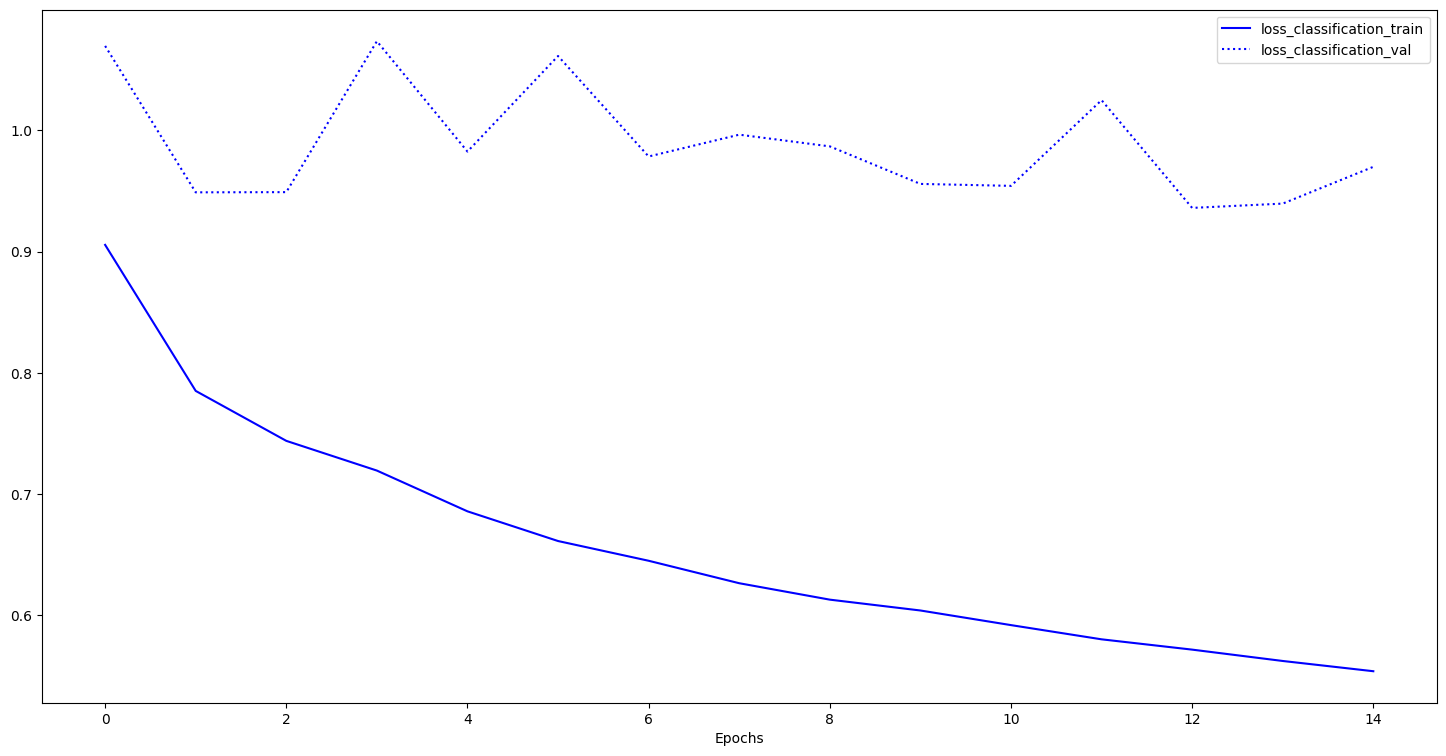

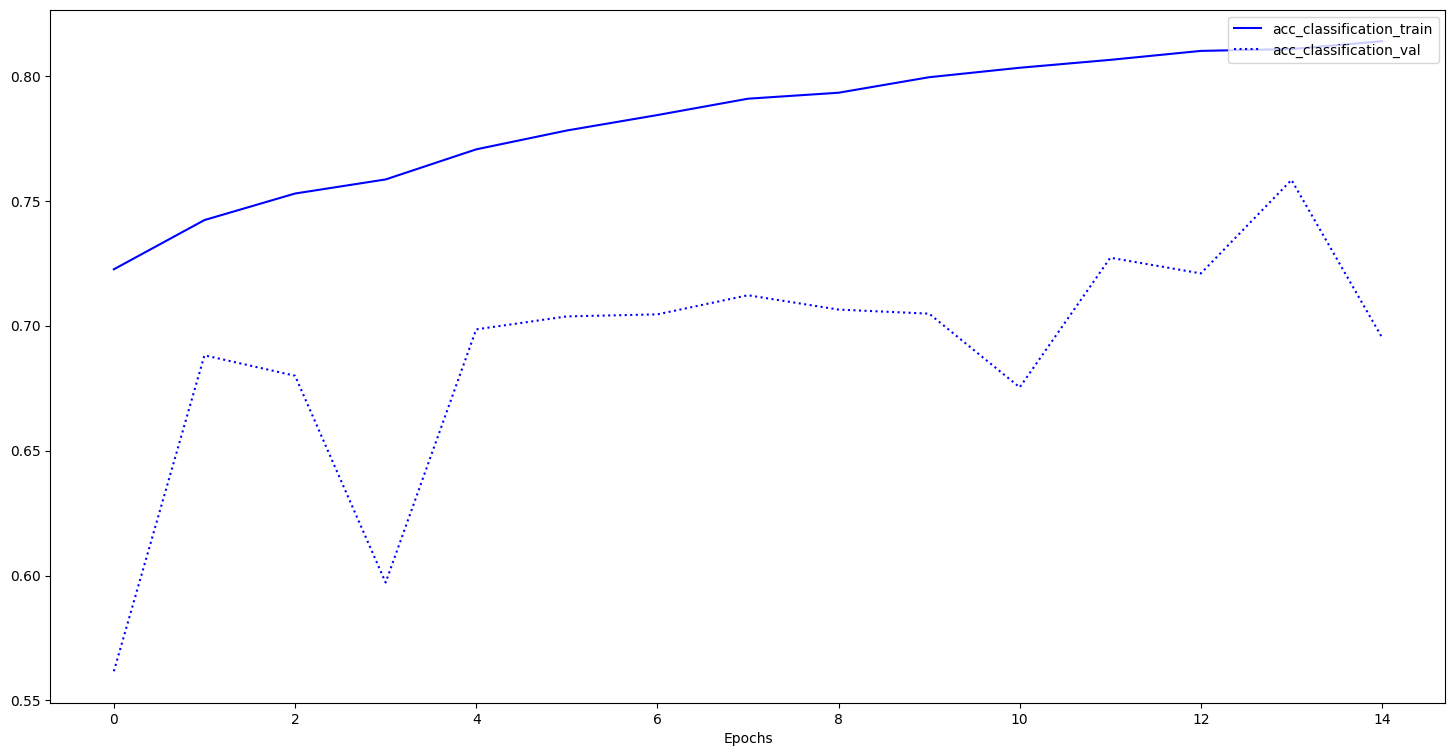

In [ ]:
if allow_train:
    helper_functions.plot_loss_curves(train_results, val_results)
    helper_functions.plot_acc_curves(train_results, val_results)

per class scores: precision: [0.94241944 0.         0.57030371 0.18601399 0.64848485] | recall: [0.98836565 0.         0.50750751 0.68911917 0.36271186] | f1_score: [0.96484586 0.         0.53707627 0.29295154 0.46521739]
average scores: precision: 0.4694443973154182 | recall: 0.5095408387736544 | f1_score: 0.45201821339389137
accuracy: 0.6911523757509558
QWK:  0.8582760308649525


c:\Users\User\.conda\envs\EnvMasoudi\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\.conda\envs\EnvMasoudi\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


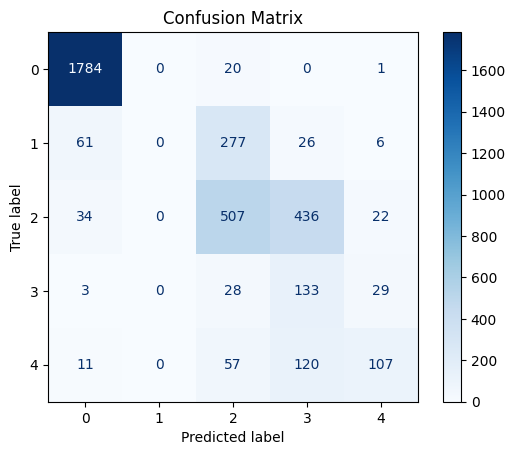

In [ ]:
# results is for APTOS-2019

test_results = engine.test_step(
    model=model,
    dataloader=val_dataloader,
    device=device)

per class scores: precision: [0.84260695 0.         0.73397603 0.59566787 0.89156627] | recall: [0.98981015 0.         0.53231293 0.37800687 0.52259887] | f1_score: [0.91029593 0.         0.61708653 0.46250876 0.65894924]
average scores: precision: 0.6127634220835184 | recall: 0.4845457638366044 | f1_score: 0.5297680912243543
accuracy: 0.8274212833798326
QWK:  0.7197740124202926


c:\Users\User\.conda\envs\EnvMasoudi\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\.conda\envs\EnvMasoudi\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


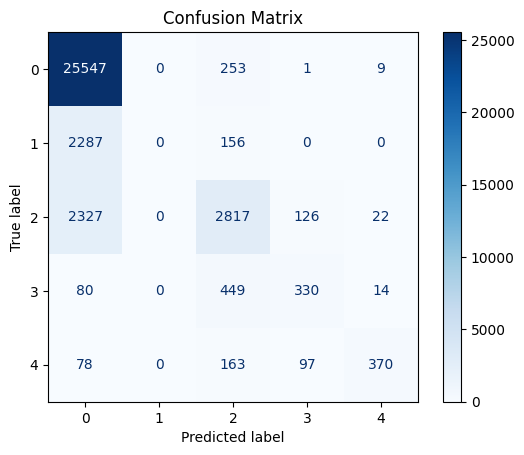

In [ ]:
# results is for APTOS-2015

test_results = engine.test_step(
    model=model,
    dataloader=train_exp_dataloader,
    device=device)

In [ ]:
helper_functions.plot_t_SNE(model=model,
                        dataloader=val_dataloader,
                        perp_vals=[5, 40],
                        NUM_ITER=2000)